In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit 
import matplotlib.colors as colors

In [2]:
def sin_func(t, A, f, phi):
    return A * np.sin(2 * np.pi * f * t + phi)


def dec_sin_func(t, g, f, phi, A=1.0):
    return A * np.exp(-1* g * t) * np.sin(2 * np.pi * f * t + phi)


def ls_laplace(time, data, data_std, decays, freqs, phis, collapse_phi=True, A=1.0):
    freq_errors=[]
    for f in freqs:
        decay_errors = []
        for g in decays: 
            phi_errors=[]
            for phi in phis:
                model = dec_sin_func(time, g, f, phi, A=A)
                sq_err = 0.5*np.sum(1/(data_std**2) * (data - model)**2)
                phi_errors.append(sq_err)
            if collapse_phi:
                decay_errors.append(np.min(phi_errors))
            else:
                decay_errors.append(phi_errors)
        freq_errors.append(decay_errors)
    return np.array(freq_errors)  


class Fringe:
    def __init__(self, g, f_0, phi, A=1.0):
        self.f_0 = f_0
        self.g = g
        self.A = A
        self.phi = phi

    def eval_pure(self, t):
        return self.A * np.exp(-1 * self.g * t) * np.sin(2 * np.pi * self.f_0 * t + self.phi)

    def add_noise(self, data, noise_level):
        noise = np.random.normal(0, noise_level, size=data.shape)
        return data + noise
    
    def eval_noisy(self, t):
        data_pure = self.eval_pure(t)
        data1 = self.add_noise(np.array(data_pure), noise_level=0.2)
        data2 = self.add_noise(np.array(data_pure), noise_level=0.2)
        data3 = self.add_noise(np.array(data_pure), noise_level=0.3)
        data_avg = np.mean([data1, data2, data3], axis=0)
        data_std = np.std([data1, data2, data3], axis=0)

        return data_avg, data_std


def gen_sample(fringe, t_hold_center, f_samp, no_samp, want_noise=True):
    if no_samp % 2 == 0:
        raise ValueError("no_samp must be odd")
    dt = 1 / f_samp
    half_span = (no_samp - 1) // 2 * dt
    t_range = np.linspace(t_hold_center - half_span, 
                          t_hold_center + half_span, 
                          no_samp)
    if want_noise:
        avg, std = fringe.eval_noisy(t_range)
    else:
        avg = fringe.eval_pure(t_range)
        std = np.ones_like(avg)*0.01
    # print(t_range)
    return t_range, avg, std


def gen_sample_by_width_and_no(fringe, t_hold_center, width, no_samp):
    t_range = np.linspace(t_hold_center - width / 2, t_hold_center + width / 2, no_samp)
    r_samp = 1/(t_range[1] - t_range[0])
    if r_samp < 2 * fringe.f_0:
        print(f"Warning: Sampling rate {r_samp} is less than twice the signal frequency {fringe.f_0}")
    avg, std = fringe.eval_noisy(t_range)
    return t_range, avg, std


In [162]:
### CODE BANK ###

# def gen_ellipse(pcov_subspace, popt_subvector, s=5.991):
    
#     # Get ellipse center
#     x_0 = popt_subvector[0]  # frequency
#     y_0 = popt_subvector[1]  # phase
    
#     #get eigvals, eigvecs of cov matrix. Eigvals are the variances in pre-rotated frame
#     evals, evecs = np.linalg.eigh(pcov_subspace)

#     # Generate ellipse parametrically
#     t = np.linspace(0, 2*np.pi, 100)
#     a = np.sqrt(s * evals[0]) 
#     b = np.sqrt(s * evals[1])
#     x_std = a * np.cos(t)
#     y_std = b * np.sin(t)

#     # stack to prep for rotation by matrix mult
#     points_std = np.vstack([x_std, y_std])
    
#     # Eigvec matrix happens to be rotation matrix we need
#     rotated_points = evecs @ points_std
    
#     # Translate to be centered on the fit convergence value
#     rotated_points[0] = rotated_points[0] + x_0
#     rotated_points[1] = rotated_points[1] + y_0

#     return rotated_points


# def fit_and_plot(time, data, data_unc, init_guess, color, no, ax=None):
#     popt, pcov = curve_fit(sin_func, time, data, p0=init_guess, sigma=data_unc)
#     print(f'Fit {no} Results:')
#     print(f'  Offset: {popt[0]:.3f} ± {np.sqrt(pcov[0, 0]):.3f}')
#     print(f'  Amplitude: {popt[1]:.3f} ± {np.sqrt(pcov[1, 1]):.3f}')
#     print(f'  Freq: {popt[2]*1e-3:.3f} ± {np.sqrt(pcov[2, 2])*1e-3:.3f} (kHz)')
#     print(f'  Phase: {popt[3]/np.pi:.3f} ± {np.sqrt(pcov[3,3])/np.pi:.3f} (π rad)')
    
#     sub_vec = popt[2:]
#     sub_mat = pcov[2:, 2:]
#     rot_ellipse = gen_ellipse(sub_mat, sub_vec)
    
#     # Use provided ax or current axes
#     if ax is None:
#         ax = plt.gca()  # Get current axes
    
#     ax.plot(rot_ellipse[0]*1e-3, rot_ellipse[1]/np.pi, label=f'Fit {no} Ellipse', color=color)
#     ax.plot(popt[2]*1e-3, popt[3]/np.pi, '*', label=f'Fit {no} Convergence', color=color, markersize=10)
#     ax.plot(np.array([init_guess[2],popt[2]])*1e-3, np.array([init_guess[3],popt[3]])/np.pi, label=f'Fit {no} Path', color=color, linestyle='--')
#     return popt, pcov


# def find_global_min(errors_gate_2d, freq_range, phi_range):
#     global_min_idx = np.unravel_index(np.argmin(errors_gate_2d), errors_gate_2d.shape)
#     return freq_range[global_min_idx[0]], phi_range[global_min_idx[1]]  

In [3]:
# Constants 

TRU_FREQ = 25e3 
TRU_TAU = 1/TRU_FREQ
# TRU_G = 1/(1/TRU_FREQ * 1000)
TRU_G = 0
F_SAMP = np.pi * TRU_FREQ * 1.5  # use irrational number to avoid patterned fringe sampling

if F_SAMP <= 2 * TRU_FREQ:
    raise ValueError("Sampling frequency must be greater than twice the true frequency, as per Nyquist Criterion")

print(f'Sample freq = {F_SAMP/TRU_FREQ} times the true frequency')

TRU_FRINGE = Fringe(g=TRU_G, f_0=TRU_FREQ, phi=0)

Sample freq = 4.712388980384689 times the true frequency


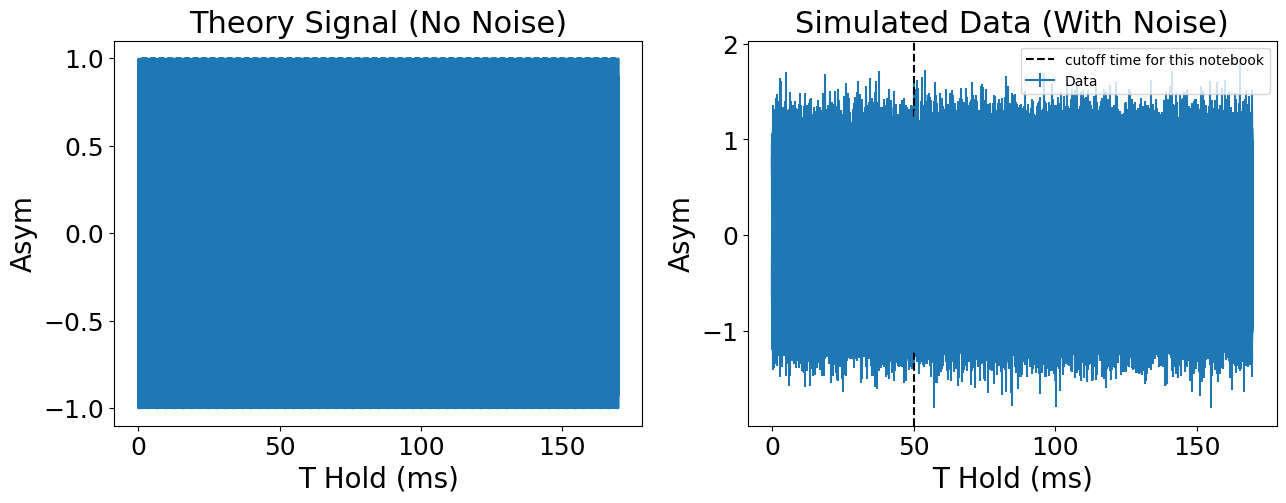

In [6]:
s_no = 20001

t0, avg0, std0 = gen_sample(TRU_FRINGE, t_hold_center=(1/F_SAMP)*s_no/2, f_samp=F_SAMP, no_samp=s_no, want_noise=False)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(t0*1e3, avg0, label='Average')
ax[0].set_xlabel('T Hold (ms)')
ax[0].set_ylabel('Asym')
ax[0].set_title('Theory Signal (No Noise)')

t0, avg0, std0 = gen_sample(TRU_FRINGE, t_hold_center=(1/F_SAMP)*s_no/2, f_samp=F_SAMP, no_samp=s_no, want_noise=True)

ax[1].errorbar(t0*1e3, avg0, yerr=std0, label='Data')
ax[1].set_xlabel('T Hold (ms)')
ax[1].set_ylabel('Asym')
ax[1].set_title('Simulated Data (With Noise)')
ax[1].axvline(x=50, color='k', linestyle='--', label='cutoff time for this notebook')
ax[1].legend()

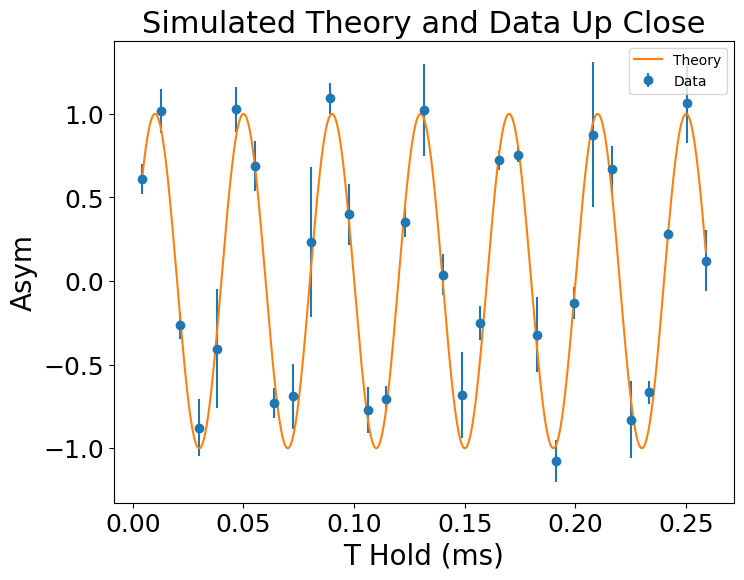

In [131]:
s_no = 31

t0, avg0, std0 = gen_sample(TRU_FRINGE, t_hold_center=(1/F_SAMP)*s_no/2, f_samp=F_SAMP, no_samp=s_no, want_noise=True)

plt.errorbar(t0*1e3, avg0, yerr=std0, fmt = 'o', label='Data')

t0, avg0, std0 = gen_sample(TRU_FRINGE, t_hold_center=(1/F_SAMP)*s_no/2, f_samp=F_SAMP*100, no_samp=(s_no-1)*100+1, want_noise=False)

plt.plot(t0*1e3, avg0, label='Theory')

plt.xlabel('T Hold (ms)')
plt.ylabel('Asym')
plt.title('Simulated Theory and Data Up Close')
plt.legend()

### First Thing To Investigate: ###

How does no samples per single slit, as well as total single slit time affect the spectrum? 

### FRINGE LENGTH EXPERIMENT ###

looks like it narrows envelope spectrum

In [8]:
t_cents = [0.2e-3, 2e-3]

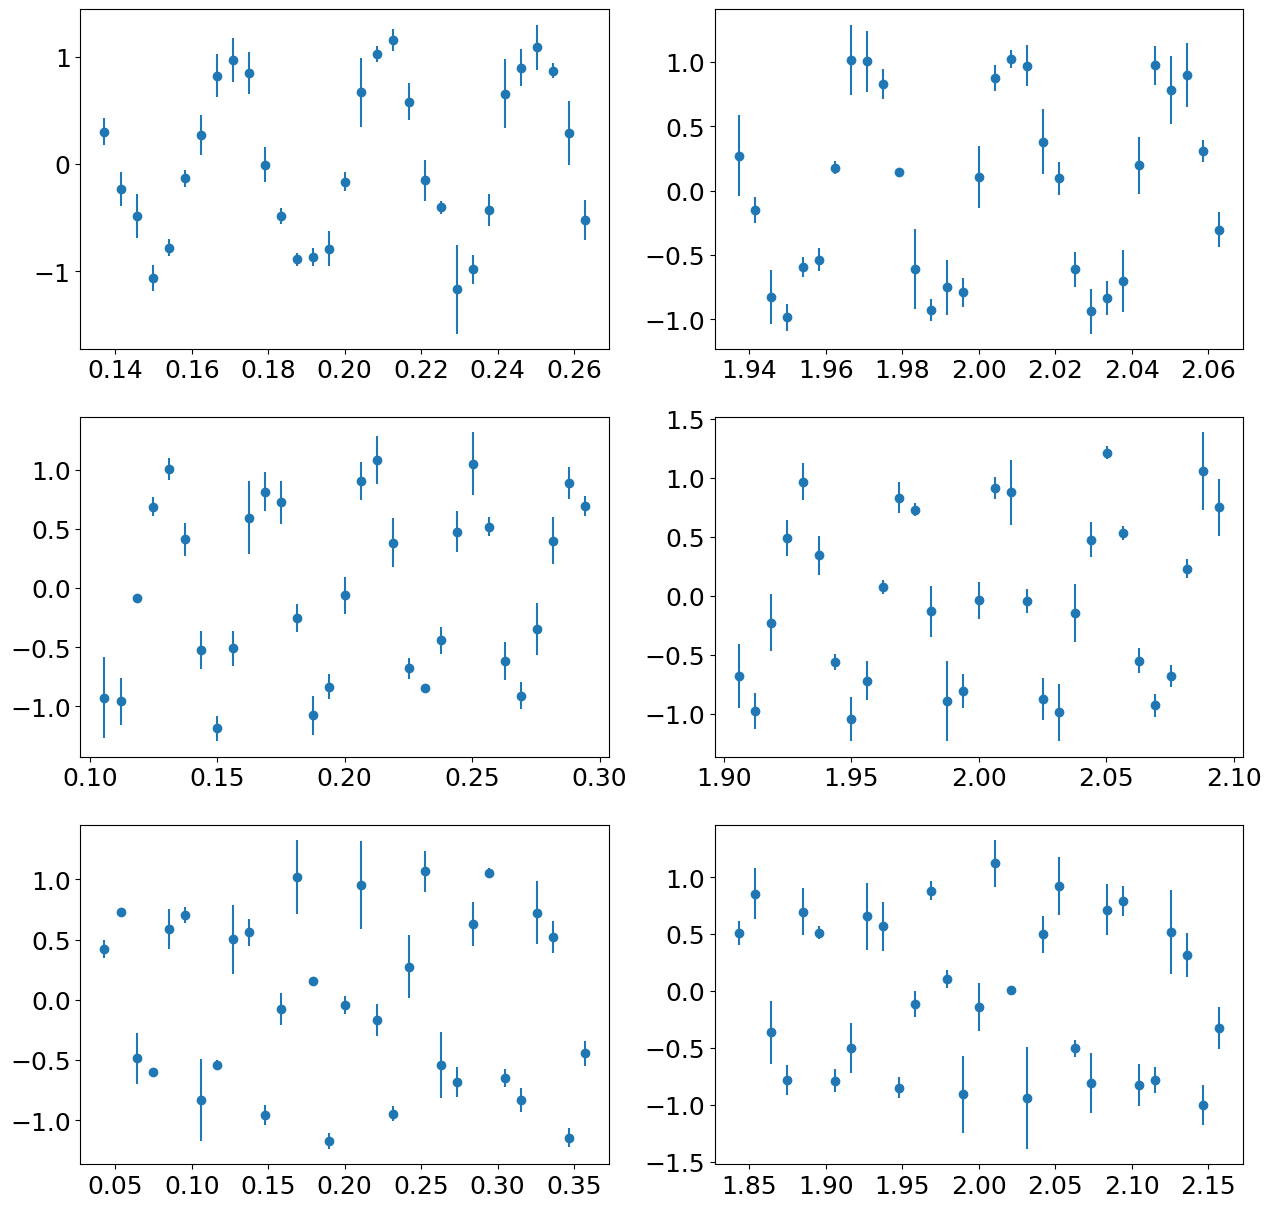

In [ ]:


widths = [np.pi*TRU_TAU, 1.5*np.pi*TRU_TAU, 2.5*np.pi*TRU_TAU]
no_samp = 31

fringe_1_ts = []
fringe_1_avgs = []
fringe_1_stds = []
fringe_2_ts = []
fringe_2_avgs = []
fringe_2_stds = []

fig, ax = plt.subplots(len(widths), len(t_cents), figsize=(15, 5*len(widths)))
for i in range(len(widths)):
    for j in range(len(t_cents)):
        t, avg, std = gen_sample_by_width_and_no(TRU_FRINGE, t_cents[j], widths[i], no_samp)
        ax[i,j].errorbar(t*1e3, avg, yerr=std, fmt='o', label='Data')
        if j == 0:
            fringe_1_ts.append(t)
            fringe_1_avgs.append(avg)
            fringe_1_stds.append(std)
        else:
            fringe_2_ts.append(t)
            fringe_2_avgs.append(avg)
            fringe_2_stds.append(std)

In [225]:
FREQ_RANGE_TEMP = np.linspace(10, 40, 3001)*1e3
PHI_RANGE_TEMP = np.linspace(0, 2*np.pi, 61)
DEC_RANGE_TEMP = [TRU_G]

In [220]:
samp_fs = []
for t in fringe_1_ts:
    samp_fs.append(1/(t[1]-t[0]))

ss1_errs = []
ss2_errs = []
ds_errs = []
for i in range(len(widths)):
    print(f'Calculating errors for fringe width {widths[i]*1e3:.2f} ms and sample rate {samp_fs[i]*1e-3:.2f} kHz')
    ss1_errs.append(ls_laplace(fringe_1_ts[i], 
                        fringe_1_avgs[i], 
                        fringe_1_stds[i],
                        DEC_RANGE_TEMP, FREQ_RANGE_TEMP, PHI_RANGE_TEMP))
    ss2_errs.append(ls_laplace(fringe_2_ts[i], 
                        fringe_2_avgs[i], 
                        fringe_2_stds[i],
                        DEC_RANGE_TEMP, FREQ_RANGE_TEMP, PHI_RANGE_TEMP))
    ds_errs.append(ls_laplace(np.concatenate([fringe_1_ts[i], fringe_2_ts[i]]),
                        np.concatenate([fringe_1_avgs[i], fringe_2_avgs[i]]),
                        np.concatenate([fringe_1_stds[i], fringe_2_stds[i]]),
                        DEC_RANGE_TEMP, FREQ_RANGE_TEMP, PHI_RANGE_TEMP))

Calculating errors for fringe width 0.13 ms and sample rate 238.73 kHz
Calculating errors for fringe width 0.19 ms and sample rate 159.15 kHz
Calculating errors for fringe width 0.31 ms and sample rate 95.49 kHz


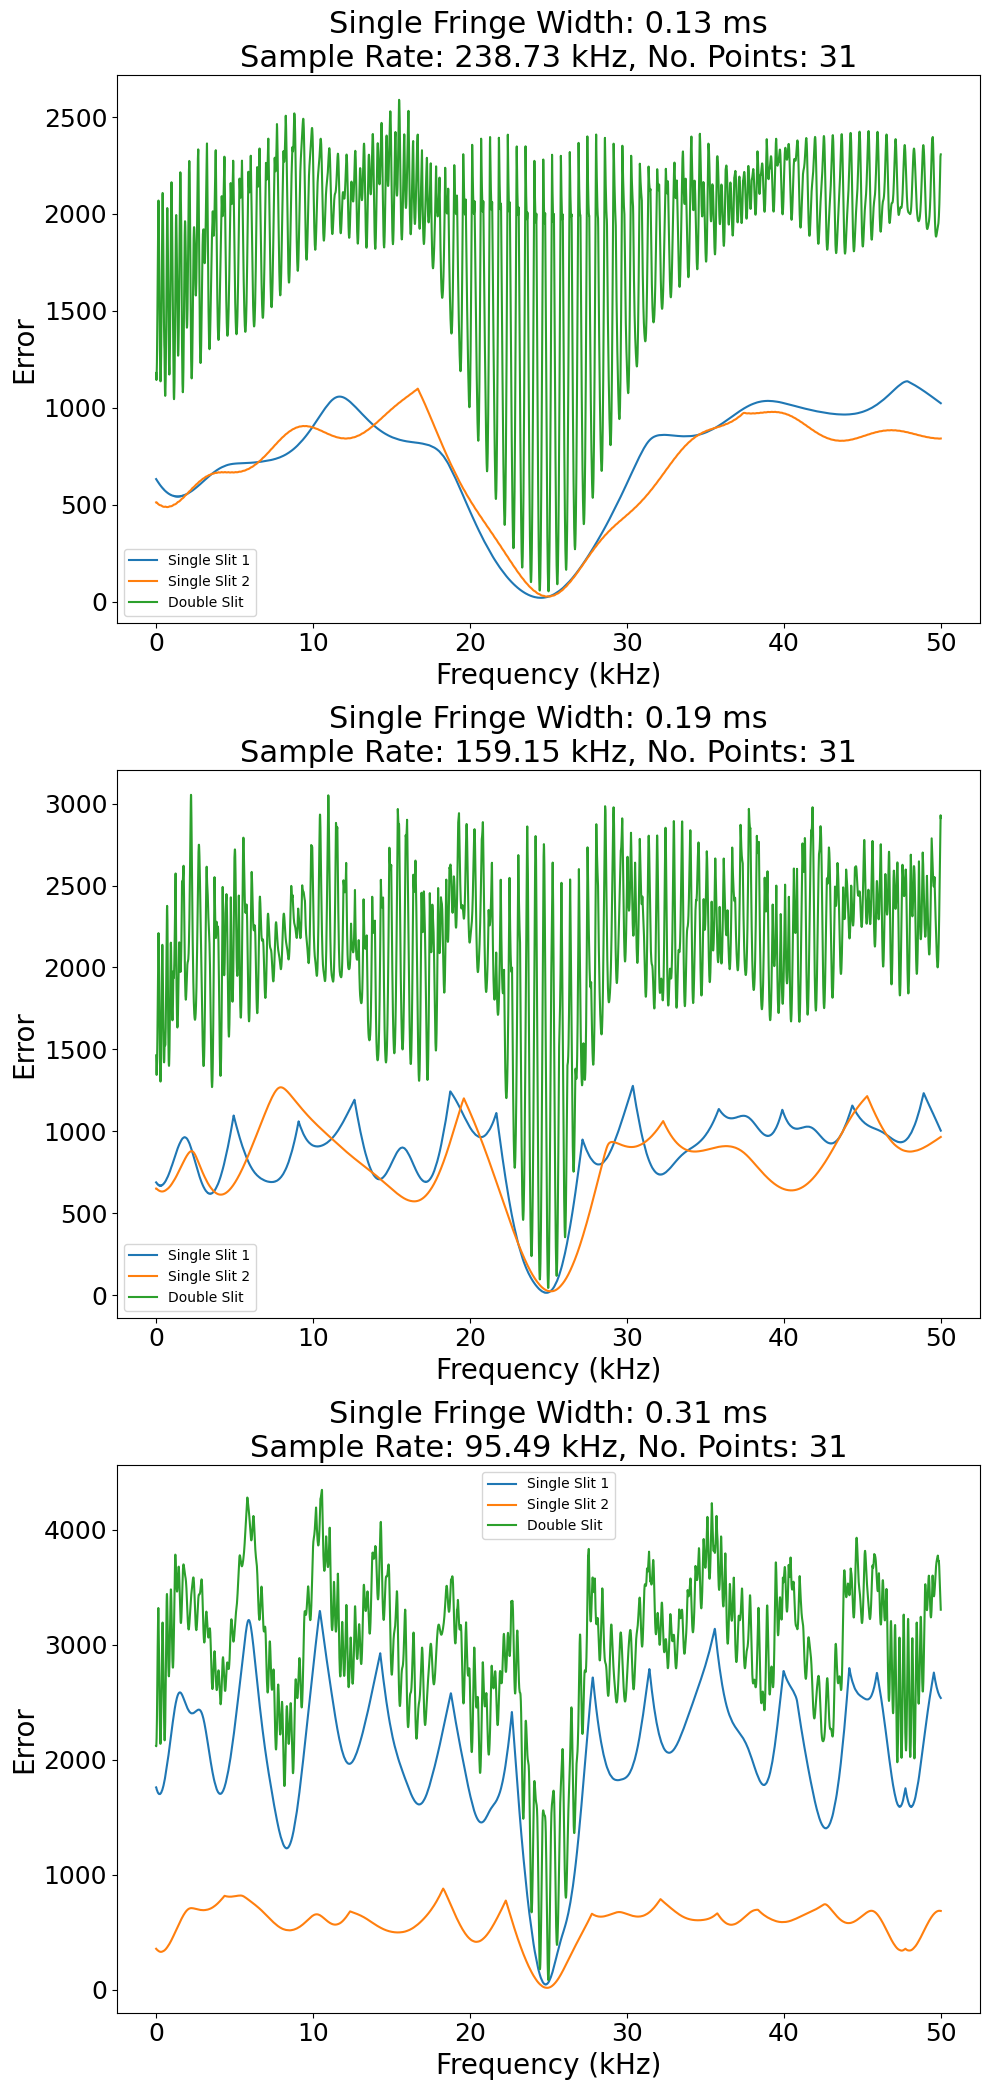

In [224]:

fig, ax = plt.subplots(len(widths), 1, figsize=(10, 7*len(widths)))

for i in range(len(widths)):
    ss1_err = ss1_errs[i]
    ss2_err = ss2_errs[i]
    ds_err = ds_errs[i]
    ax[i].plot(FREQ_RANGE_TEMP*1e-3, ss1_err, label='Single Slit 1')
    ax[i].plot(FREQ_RANGE_TEMP*1e-3, ss2_err, label='Single Slit 2')
    ax[i].plot(FREQ_RANGE_TEMP*1e-3, ds_err, label='Double Slit')
    ax[i].set_title(f'Single Fringe Width: {widths[i]*1e3:.2f} ms\nSample Rate: {samp_fs[i]*1e-3:.2f} kHz, No. Points: {no_samp}')
    ax[i].set_xlabel('Frequency (kHz)')
    ax[i].set_ylabel('Error')
    ax[i].legend()

plt.tight_layout()

### SAMPLE RATE EXPERIMENT ###

probably stabilizes the spectrum (better stats?)

gate width containts 2.5 periods of fringe
Number of samples: 7
try no: 0
try no: 1
try no: 2
try no: 3
try no: 4
try no: 5
try no: 6
try no: 7
try no: 8
try no: 9
Number of samples: 15
try no: 0
try no: 1
try no: 2
try no: 3
try no: 4
try no: 5
try no: 6
try no: 7
try no: 8
try no: 9
Number of samples: 63
try no: 0
try no: 1
try no: 2
try no: 3
try no: 4
try no: 5
try no: 6
try no: 7
try no: 8
try no: 9


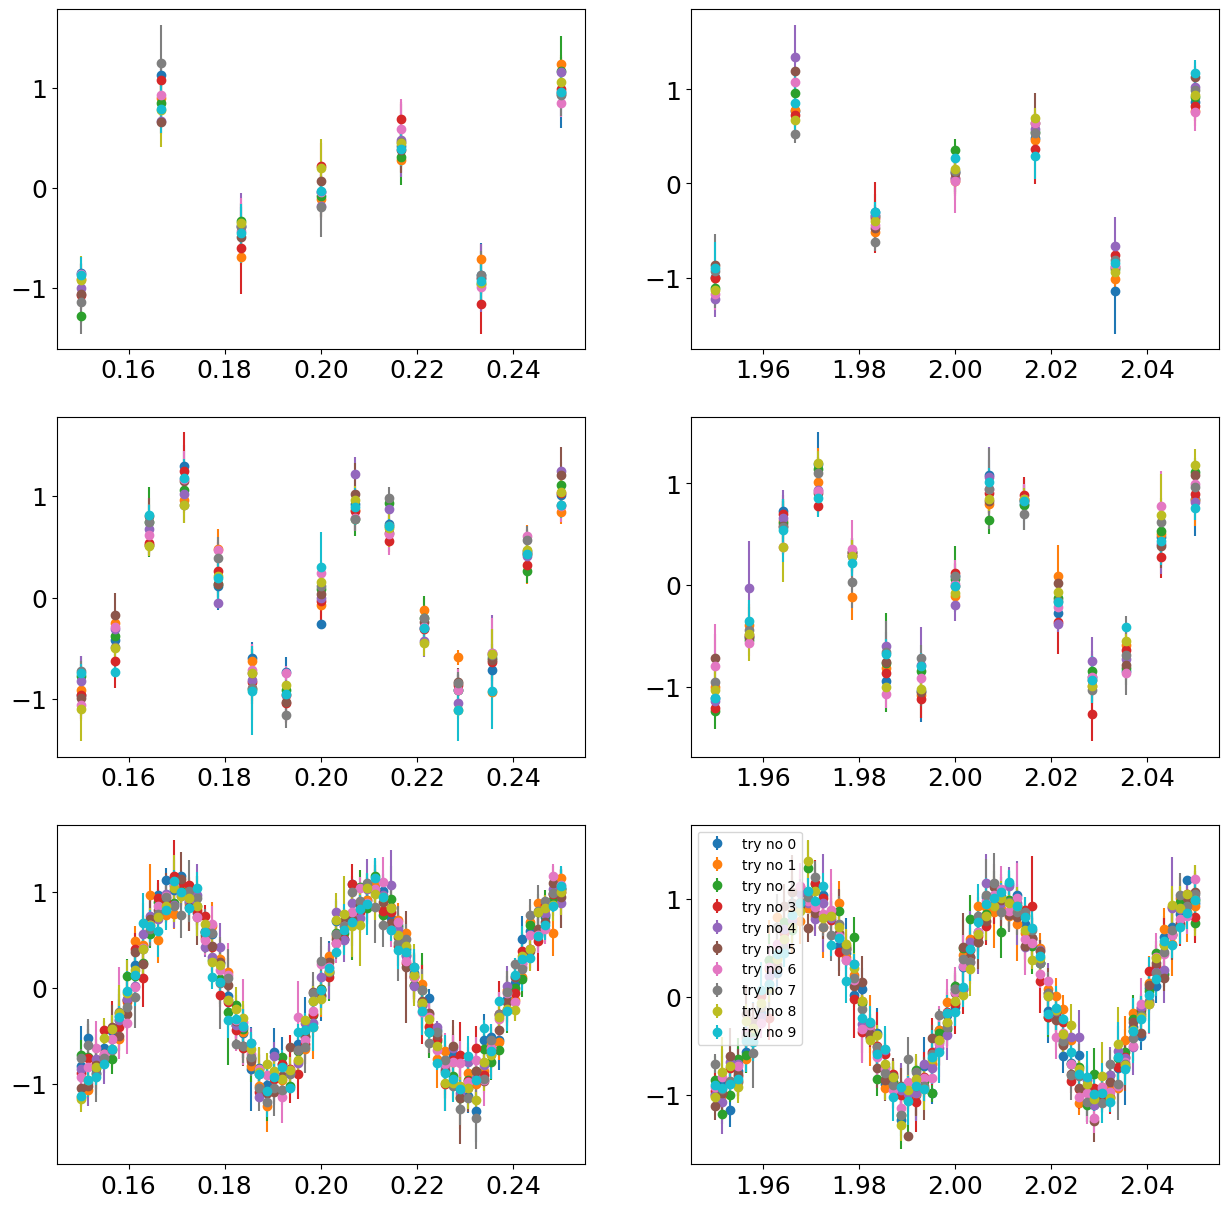

In [34]:
no_tries = 10
gate_width = 0.1e-3 
print(f'gate width containts {gate_width/TRU_TAU} periods of fringe')

no_samps = [7,15,63]

fig, ax = plt.subplots(3, 2, figsize=(15, 15))

for i in range(len(no_samps)):
    no_samp = no_samps[i]

    print(f'Number of samples: {no_samp}')
    ss_array_all_tries = []
    ds_array_all_tries = []

    for j in range(no_tries):

        print(f'try no: {j}')
        t, avg, std = gen_sample_by_width_and_no(TRU_FRINGE, t_hold_center=t_cents[0], width=gate_width,
                                                    no_samp=no_samp)
        
        ax[i,0].errorbar(t*1e3, avg, yerr=std, fmt='o', label=f'try no {j}')

        ss_array_all_tries.append([t, avg, std])

        t, avg, std = gen_sample_by_width_and_no(TRU_FRINGE, t_hold_center=t_cents[1], width=gate_width,
                                                    no_samp=no_samp)
        ax[i,1].errorbar(t*1e3, avg, yerr=std, fmt='o', label=f'try no {j}')

        ds_array_all_tries.append([t, avg, std])

    if i == 0:
        stat_1_ss = ss_array_all_tries
        stat_1_ds = ds_array_all_tries
    elif i == 1:
        stat_2_ss = ss_array_all_tries
        stat_2_ds = ds_array_all_tries
    elif i == 2:
        stat_3_ss = ss_array_all_tries
        stat_3_ds = ds_array_all_tries
    else:
        raise ValueError("Need to rewrite loop")

plt.legend()
stat_1_ss = np.array(stat_1_ss)
stat_1_ds = np.array(stat_1_ds)

stat_2_ss = np.array(stat_2_ss)
stat_2_ds = np.array(stat_2_ds)

stat_3_ss = np.array(stat_3_ss)
stat_3_ds = np.array(stat_3_ds)


In [35]:
FREQ_RANGE_TEMP = np.linspace(10, 40, 3001)*1e3
PHI_RANGE_TEMP = np.linspace(0, 2*np.pi, 61)
DEC_RANGE_TEMP = [TRU_G]

In [36]:
means_all_samp_no_ss = []
stds_all_samp_no_ss = []
mins_all_samp_no_ss = []
maxs_all_samp_no_ss = []

means_all_samp_no_ds = []
stds_all_samp_no_ds = []
mins_all_samp_no_ds = []
maxs_all_samp_no_ds = []

for j in range(3):    
    ss_errs = [] # these are stacked spectra for a single samp no type
    ds_errs = []

    for i in range(no_tries):
        if j == 0:
            t_curr1 = stat_1_ss[i,0]
            avg_curr1 = stat_1_ss[i,1]
            std_curr1 = stat_1_ss[i,2]

            t_curr2 = stat_1_ds[i,0]
            avg_curr2 = stat_1_ds[i,1]
            std_curr2 = stat_1_ds[i,2]
        elif j == 1:
            t_curr1 = stat_2_ss[i,0]
            avg_curr1 = stat_2_ss[i,1]
            std_curr1 = stat_2_ss[i,2]

            t_curr2 = stat_2_ds[i,0]
            avg_curr2 = stat_2_ds[i,1]
            std_curr2 = stat_2_ds[i,2]
        elif j == 2:
            t_curr1 = stat_3_ss[i,0]
            avg_curr1 = stat_3_ss[i,1]
            std_curr1 = stat_3_ss[i,2]

            t_curr2 = stat_3_ds[i,0]
            avg_curr2 = stat_3_ds[i,1]
            std_curr2 = stat_3_ds[i,2]

        ss_errs.append(ls_laplace(t_curr1, 
                            avg_curr1, 
                            std_curr1,
                            DEC_RANGE_TEMP, FREQ_RANGE_TEMP, PHI_RANGE_TEMP))

        ds_errs.append(ls_laplace(np.concatenate([t_curr1, t_curr2]), 
                            np.concatenate([avg_curr1, avg_curr2]), 
                            np.concatenate([std_curr1, std_curr2]),
                            DEC_RANGE_TEMP, FREQ_RANGE_TEMP, PHI_RANGE_TEMP))

    means_all_samp_no_ss.append(np.mean(np.array(ss_errs), axis=0)[:,0])
    stds_all_samp_no_ss.append(np.std(np.array(ss_errs), axis=0)[:,0])
    mins_all_samp_no_ss.append(np.min(np.array(ss_errs), axis=0)[:,0])
    maxs_all_samp_no_ss.append(np.max(np.array(ss_errs), axis=0)[:,0])

    means_all_samp_no_ds.append(np.mean(np.array(ds_errs), axis=0)[:,0])
    stds_all_samp_no_ds.append(np.std(np.array(ds_errs), axis=0)[:,0])
    mins_all_samp_no_ds.append(np.min(np.array(ds_errs), axis=0)[:,0])
    maxs_all_samp_no_ds.append(np.max(np.array(ds_errs), axis=0)[:,0])




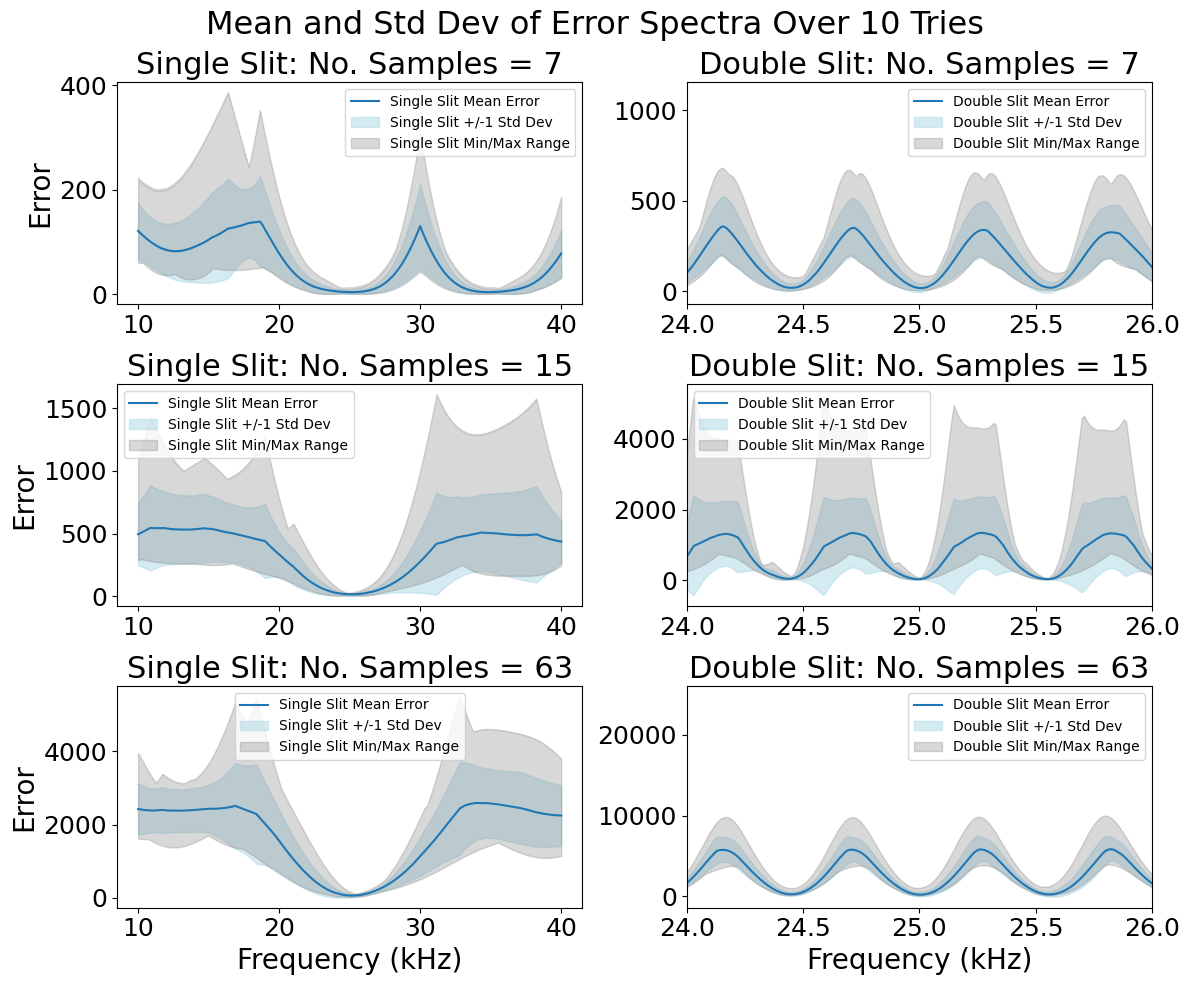

In [38]:
fig, ax = plt.subplots(3, 2, figsize=(12, 10))

for i in range(3):
    ax[i, 0].plot(FREQ_RANGE_TEMP*1e-3, means_all_samp_no_ss[i], label='Single Slit Mean Error')
    ax[i, 0].fill_between(FREQ_RANGE_TEMP*1e-3, 
                        means_all_samp_no_ss[i]-stds_all_samp_no_ss[i],
                        means_all_samp_no_ss[i]+stds_all_samp_no_ss[i],
                        color='lightblue', alpha=0.5, label='Single Slit +/-1 Std Dev')
    
    ax[i, 0].fill_between(FREQ_RANGE_TEMP*1e-3, 
                        mins_all_samp_no_ss[i],
                        maxs_all_samp_no_ss[i],
                        color='gray', alpha=0.3, label='Single Slit Min/Max Range')
    
    ax[i, 0].set_title(f'Single Slit: No. Samples = {no_samps[i]}')
    ax[i, 0].set_ylabel('Error')
    ax[i, 0].legend()
    ax[i, 1].plot(FREQ_RANGE_TEMP*1e-3, means_all_samp_no_ds[i], label='Double Slit Mean Error')
    ax[i, 1].fill_between(FREQ_RANGE_TEMP*1e-3, 
                        means_all_samp_no_ds[i]-stds_all_samp_no_ds[i],
                        means_all_samp_no_ds[i]+stds_all_samp_no_ds[i],
                        color='lightblue', alpha=0.5, label='Double Slit +/-1 Std Dev')
    ax[i, 1].fill_between(FREQ_RANGE_TEMP*1e-3, 
                        mins_all_samp_no_ds[i],
                        maxs_all_samp_no_ds[i],
                        color='gray', alpha=0.3, label='Double Slit Min/Max Range')
    ax[i, 1].set_title(f'Double Slit: No. Samples = {no_samps[i]}')
    ax[i, 1].set_xlim(24,26)
    ax[i, 1].legend()


ax[2, 0].set_xlabel('Frequency (kHz)')
ax[2, 1].set_xlabel('Frequency (kHz)')
fig.suptitle(f'Mean and Std Dev of Error Spectra Over {no_tries} Tries', fontsize=23)

plt.tight_layout()




### Harmonic Elimination Experiment ###

Predict that the nearest neighbor peaks will be attentuated by placing sampling periods at 1/2, 1/3, 1/4, ... 1/N of the furthest two slit spacing. N is the no. peaks from the center freq. +1

Turns out that you actually attempt to disrupt the 1,2,4,8, and 16th order peaks. Do this using the formula 0.5/N to find the fractional separation time wrt the separation time of the two most separated fringes

In [15]:
NO_NODE_FRINGES = 4
NO_FRINGES = NO_NODE_FRINGES + 2
start_t_center = (1/TRU_FREQ)* 5
end_t_center = (1/TRU_FREQ) * 150
tc_sep = end_t_center - start_t_center
t_centers = [start_t_center]

for i in range(1,NO_NODE_FRINGES+1):
    t_centers.append(start_t_center + tc_sep * 1/(2**i))

t_centers.append(end_t_center)

t_centers = np.sort(np.array(t_centers))

print(f'first t center: {start_t_center*1e3} ms')
print((t_centers-start_t_center)*1e3)
print((t_centers-start_t_center)/tc_sep)

first t center: 0.2 ms
[0.     0.3625 0.725  1.45   2.9    5.8   ]
[0.     0.0625 0.125  0.25   0.5    1.    ]


In [16]:
F_SAMP = np.pi * TRU_FREQ * 1.5  # use irrational number to avoid patterned fringe sampling
print(f'Sample freq = {F_SAMP/TRU_FREQ} times the true frequency')

Sample freq = 4.712388980384689 times the true frequency


In [17]:
samp_no = 11

all_times = []
all_avgs = []
all_stds = []

for i in range(NO_FRINGES):
    t, avg, std = gen_sample(TRU_FRINGE, t_hold_center=t_centers[i], f_samp=F_SAMP, no_samp=samp_no, want_noise=True)
    all_times.append(t)
    all_avgs.append(avg)
    all_stds.append(std)

all_times = np.array(all_times)
all_avgs = np.array(all_avgs)
all_stds = np.array(all_stds)

Text(0.5, 0.98, 'Simulated Data from Multiple Fringes\nFringe Time Choices Eliminate Closest Sidebands')

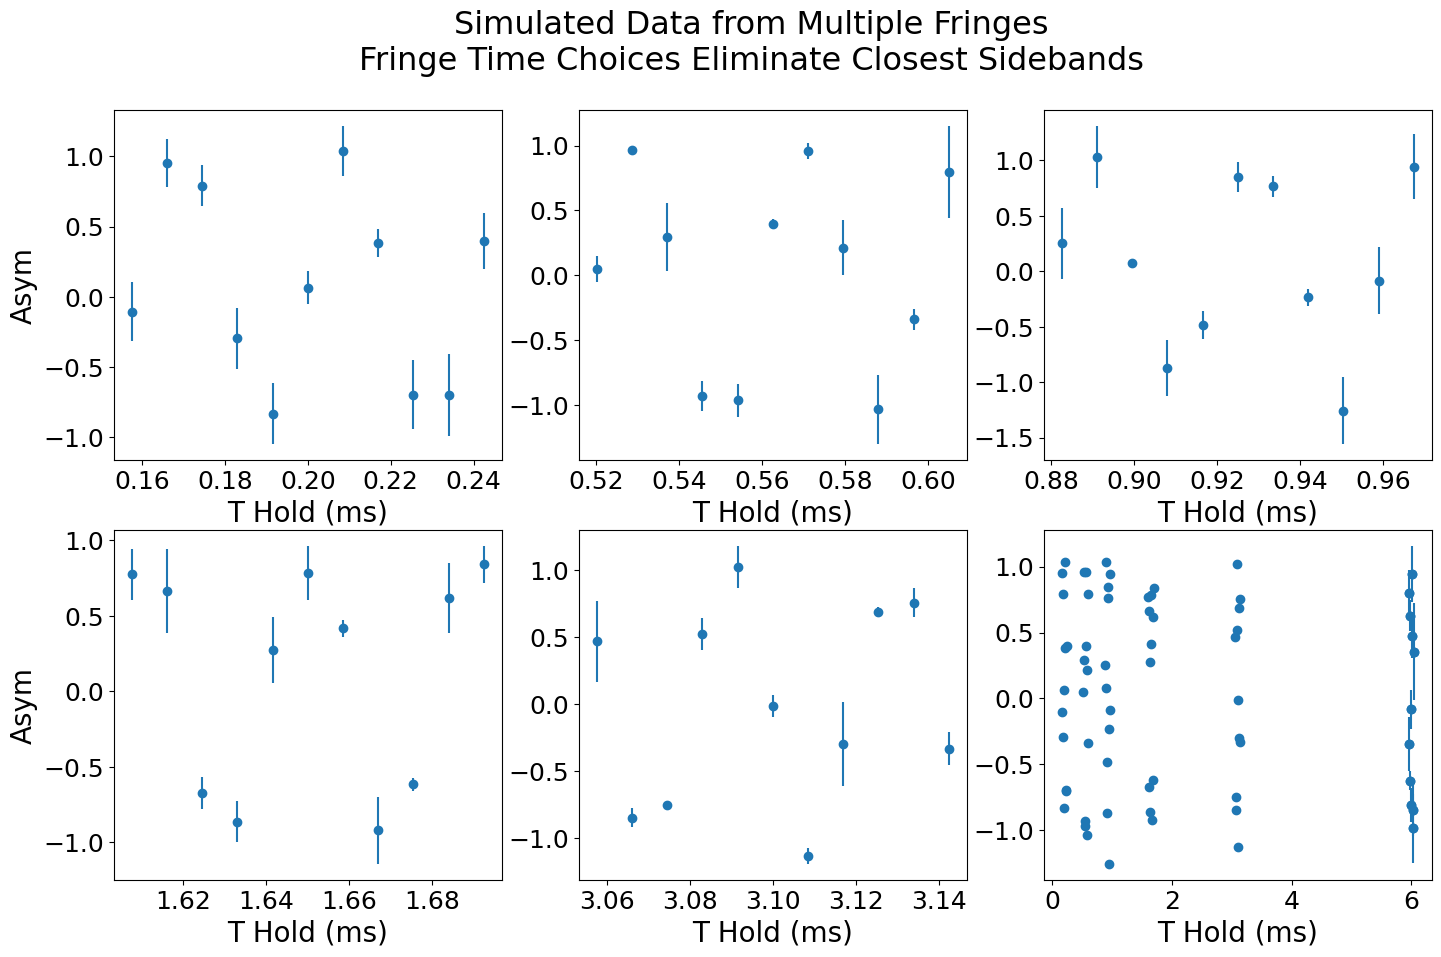

In [18]:
fig, ax = plt.subplots(2, 3, figsize=(17, 10))
for i in range(NO_FRINGES):
    r = i // 3
    c = i % 3
    ax[r, c].errorbar(all_times[i]*1e3, all_avgs[i], yerr=all_stds[i], fmt='o', label=f'Data {i+1}')
    ax[r, c].set_xlabel('T Hold (ms)')
    # ax[r, c].set_ylabel('Asym')
    if i == 4:
        ax[1, 2].scatter(np.concatenate(all_times)*1e3, np.concatenate(all_avgs))
        ax[1, 2].set_xlabel('T Hold (ms)')
        # ax[1, 2].set_ylabel('Asym')
ax[0,0].set_ylabel('Asym')
ax[1,0].set_ylabel('Asym')
fig.suptitle('Simulated Data from Multiple Fringes\nFringe Time Choices Eliminate Closest Sidebands', fontsize=23)

In [19]:
PHI_RANGE = np.linspace(-np.pi, np.pi, 31)
FREQ_RANGE = np.linspace(20, 30, 1000)*1e3
DECAY_RANGE = np.array([0,TRU_G]) # DOESN'T MATTER FOR "HARMONICS" ANALYSIS
print(f'Frequency range step: {1e-3*(FREQ_RANGE[1]-FREQ_RANGE[0])} kHz')

Frequency range step: 0.010010010010009864 kHz


In [24]:
# Using list syntax instead of tuple:
errs = ls_laplace(np.concatenate([all_times[0], all_times[-1]]), 
                  np.concatenate([all_avgs[0], all_avgs[-1]]), 
                  np.concatenate([all_stds[0], all_stds[-1]]), 
                  DECAY_RANGE, FREQ_RANGE, PHI_RANGE, collapse_phi=True, A=1.0)[:,0]
errs_1 = ls_laplace(np.concatenate([all_times[0], all_times[-2], all_times[-1]]),
                  np.concatenate([all_avgs[0], all_avgs[-2], all_avgs[-1]]), 
                  np.concatenate([all_stds[0], all_stds[-2], all_stds[-1]]), 
                  DECAY_RANGE, FREQ_RANGE, PHI_RANGE, collapse_phi=True, A=1.0)[:,0]
errs_2 = ls_laplace(np.concatenate([all_times[0], all_times[-3], all_times[-1]]),
                  np.concatenate([all_avgs[0], all_avgs[-3], all_avgs[-1]]), 
                  np.concatenate([all_stds[0], all_stds[-3], all_stds[-1]]), 
                  DECAY_RANGE, FREQ_RANGE, PHI_RANGE, collapse_phi=True, A=1.0)[:,0]
errs_4 = ls_laplace(np.concatenate([all_times[0], all_times[-4], all_times[-1]]),
                    np.concatenate([all_avgs[0], all_avgs[-4], all_avgs[-1]]), 
                    np.concatenate([all_stds[0], all_stds[-4], all_stds[-1]]), 
                    DECAY_RANGE, FREQ_RANGE, PHI_RANGE, collapse_phi=True, A=1.0)[:,0]
errs_8 = ls_laplace(np.concatenate([all_times[0], all_times[-5], all_times[-1]]),
                    np.concatenate([all_avgs[0], all_avgs[-5], all_avgs[-1]]), 
                    np.concatenate([all_stds[0], all_stds[-5], all_stds[-1]]), 
                    DECAY_RANGE, FREQ_RANGE, PHI_RANGE, collapse_phi=True, A=1.0)[:,0]

errs_1248 = ls_laplace(np.concatenate([all_times[0], all_times[-5], all_times[-4], all_times[-3], all_times[-2], all_times[-1]]),
                    np.concatenate([all_avgs[0], all_avgs[-5], all_avgs[-4], all_avgs[-3], all_avgs[-2], all_avgs[-1]]), 
                    np.concatenate([all_stds[0], all_stds[-5], all_stds[-4], all_stds[-3], all_stds[-2], all_stds[-1]]), 
                    DECAY_RANGE, FREQ_RANGE, PHI_RANGE, collapse_phi=True, A=1.0)[:,0]




In [25]:
errs_ds_1 = ls_laplace(np.concatenate([all_times[0], all_times[-2]]),
                        np.concatenate([all_avgs[0], all_avgs[-2]]),
                        np.concatenate([all_stds[0], all_stds[-2]]),
                        DECAY_RANGE, FREQ_RANGE, PHI_RANGE, collapse_phi=True, A=1.0)[:,0]
errs_ds_2 = ls_laplace(np.concatenate([all_times[0], all_times[-3]]),
                    np.concatenate([all_avgs[0], all_avgs[-3]]),
                    np.concatenate([all_stds[0], all_stds[-3]]),
                    DECAY_RANGE, FREQ_RANGE, PHI_RANGE, collapse_phi=True, A=1.0)[:,0]
errs_ds_4 = ls_laplace(np.concatenate([all_times[0], all_times[-4]]),
                    np.concatenate([all_avgs[0], all_avgs[-4]]),
                    np.concatenate([all_stds[0], all_stds[-4]]),
                    DECAY_RANGE, FREQ_RANGE, PHI_RANGE, collapse_phi=True, A=1.0)[:,0]
errs_ds_8 = ls_laplace(np.concatenate([all_times[0], all_times[-5]]),
                    np.concatenate([all_avgs[0], all_avgs[-5]]),
                    np.concatenate([all_stds[0], all_stds[-5]]),
                    DECAY_RANGE, FREQ_RANGE, PHI_RANGE, collapse_phi=True, A=1.0)[:,0]


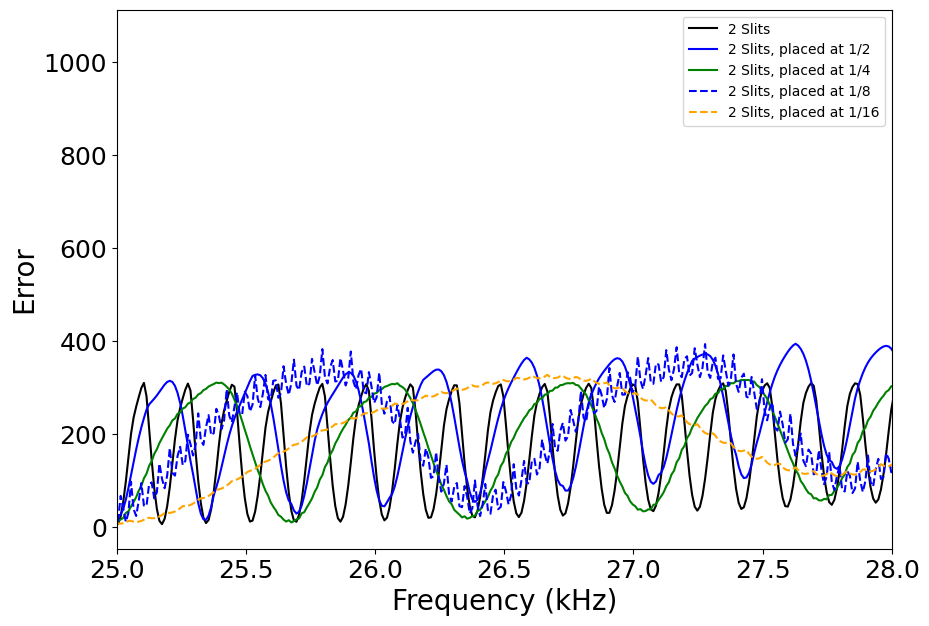

In [38]:
plt.figure(figsize=(10, 7))
plt.plot(FREQ_RANGE*1e-3, errs, color='black',label='2 Slits')

# plt.plot(FREQ_RANGE*1e-3, errs_1, color='red',label='3 Slits, placed at 1/2')
plt.plot(FREQ_RANGE*1e-3, errs_ds_1, color='blue',label='2 Slits, placed at 1/2')

# plt.plot(FREQ_RANGE*1e-3, errs_2, color='orange',label='3 Slits, placed at 1/4')
plt.plot(FREQ_RANGE*1e-3, errs_ds_2, color='green',label='2 Slits, placed at 1/4')

plt.plot(FREQ_RANGE*1e-3, errs_ds_4, color='blue',label='2 Slits, placed at 1/8', linestyle='--')
# plt.plot(FREQ_RANGE*1e-3, errs_4, color='green',label='3 Slits, placed at 1/8', linestyle='--')

# plt.plot(FREQ_RANGE*1e-3, errs_8, color='blue',label='3 Slits, placed at 1/16', linestyle='--')
plt.plot(FREQ_RANGE*1e-3, errs_ds_8, color='orange',label='2 Slits, placed at 1/16', linestyle='--')

# plt.plot(FREQ_RANGE*1e-3, errs_1248, color='cyan',label='1248', linestyle='--')

plt.xlabel('Frequency (kHz)')
plt.ylabel('Error')
plt.xlim(25, 28)
plt.legend()